In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
import torch
import logging
logging.basicConfig(level=logging.ERROR)
# If there's a GPU available...
if torch.cuda.is_available():    
 
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
 
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
 
    print('We will use the GPU:', torch.cuda.get_device_name(0))
 
# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [2]:
!pip install torchtext==0.3.1

In [3]:
import pandas as pd
data = pd.read_csv("train_sentiment_absa_restaurent.csv")
data

,text,aspect_words,labels
0,We had great desserts (including the best cann...,cannoli,2
1,Great pizza for lunch place.,pizza,2
2,It's a great place to pick up a cheap lunch or...,lunch,2
3,Its a nice quiet location to go eat a good mea...,location,2
4,"The first 2 courses were very good, but the ch...",dessert wine,0
...,...,...,...
3242,Zero ambiance to boot.,ambiance,0
3243,"Kind, attentive wait staff.",wait staff,2
3244,$20 gets you unlimited sushi of a very high qu...,sushi places,2
3245,"Their sushi, Kamikaze and other Rolls are fres...",sushi,2


In [4]:
val = pd.read_csv("val_sentiment_absa_restaurent.csv")
val

,text,aspect_words,labels
0,This is a consistently great place to dine for...,lunch,1
1,The workers there also absolutely load the bag...,workers,1
2,"If it isn't for the food (A+++), it must be th...",service,2
3,The whole set up is truly unprofessional and I...,staff,0
4,The staff was too busy ordering sushi for dinn...,sushi,1
...,...,...,...
356,We ordered some beef and noodle soup dishes fr...,beef,0
357,"Looking around, I saw a room full of New Yorke...",clubhouse,0
358,THE BIG COMPLAINT: NO TOASTING AVAILABLE.,TOASTING,0
359,Interesting other dishes for a change include ...,salmon caserole,2


In [5]:
test = pd.read_csv("test_sentiment_ABSA_restaurent.csv")
test

,text,aspect_words,labels
0,The bread is top notch as well.,bread,2
1,I have to say they have one of the fastest del...,delivery times,2
2,Food is always fresh and hot- ready to eat!,Food,2
3,Did I mention that the coffee is OUTSTANDING?,coffee,2
4,"Certainly not the best sushi in New York, howe...",place,2
...,...,...,...
1115,"Creamy appetizers--taramasalata, eggplant sala...",Creamy appetizers,2
1116,"Creamy appetizers--taramasalata, eggplant sala...",warm pitas,1
1117,"Creamy appetizers--taramasalata, eggplant sala...",taramasalata,2
1118,"Creamy appetizers--taramasalata, eggplant sala...",eggplant salad,2


In [6]:
import torchtext
text = torchtext.data.Field(lower=True, batch_first=True, tokenize='spacy', include_lengths=True)
aspect = torchtext.data.Field(lower=True, batch_first=True, tokenize='spacy', include_lengths=True)

target = torchtext.data.Field(sequential=False, use_vocab=False, is_target=True)
# use field objects to read training, validation and test sets
train = torchtext.data.TabularDataset(path='train_sentiment_absa_restaurent.csv', format='csv',
                                      fields={'text': ('text',text),
                                              'aspect_words': ('aspect',aspect),
                                              'labels': ('target',target)})
val = torchtext.data.TabularDataset(path='val_sentiment_absa_restaurent.csv', format='csv',
                                              fields={'text': ('text',text),
                                              'aspect_words': ('aspect',aspect),
                                              'labels': ('target',target)})
test = torchtext.data.TabularDataset(path='test_sentiment_ABSA_restaurent.csv', format='csv',
                                              fields={'text': ('text',text),
                                              'aspect_words': ('aspect',aspect),
                                              'labels': ('target',target)})

In [7]:
from sklearn.preprocessing import LabelEncoder
import joblib
LE =LabelEncoder()
LE=joblib.load('sentiment_label_encoder_restaurent')


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.22.1 when using version 0.22.2.post1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [8]:
def get_labels(prediction):
    predicted_label =  LE.inverse_transform([prediction])
    return predicted_label[0]

In [9]:
text.build_vocab(train, val, test,vectors="glove.6B.300d")
aspect.build_vocab(train, val, test,vectors="glove.6B.300d")



In [10]:
print(text.vocab.vectors.shape)
print(f"Unique tokens in text vocabulary: {len(text.vocab)}")

torch.Size([4454, 300])
Unique tokens in text vocabulary: 4454


In [11]:
batch_size = 32
train_iter = torchtext.data.BucketIterator(dataset=train,
                                           batch_size=batch_size,
                                           sort_key=lambda x: x.text.__len__(),
                                           shuffle=True,
                                           sort_within_batch=True) 
val_iter = torchtext.data.BucketIterator(dataset=val,
                                         batch_size=batch_size,
                                         sort_key=lambda x: x.text.__len__(),
                                         train=False,
                                         sort_within_batch=True)
test_iter = torchtext.data.BucketIterator(dataset=test,
                                          batch_size=batch_size,
                                          sort_key=lambda x: x.text.__len__(),
                                          sort_within_batch=True)

In [140]:
from torch import nn

class Attention(nn.Module):
  def __init__(self,vector_1_dim,vector_2_dim):
    super(Attention, self).__init__()
    self.Weights = nn.Parameter(torch.rand(vector_2_dim,vector_1_dim))
    self.bias = nn.Parameter(torch.zeros(1))

  def forward(self,vector_1,vector_2):
    #(batch_size,vector_2_dim,vector_1_dim)
    weights = self.Weights.repeat(vector_2.size(0),1,1)
    vector_1 = vector_1.unsqueeze(-1)  # (batch_size,vector_2_dim,vector_1_dim)
    weights = weights.matmul(vector_1) # results in (batch_size,vector_2_dim,1)
    weights = weights.repeat(vector_2.size(1),1,1,1).transpose(0,1)
    vector_2 = vector_2.unsqueeze(-2)
    attention_weights = torch.tanh(vector_2.matmul(weights).squeeze() + self.bias).squeeze() # batch_size, vector_2_dim.size(0)
    # print("torch.exp(attention_weights)",torch.exp(attention_weights).shape,attention_weights.shape,torch.exp(attention_weights).sum(dim=1).shape)
    attention_weights = torch.exp(attention_weights)/ torch.exp(attention_weights).sum(dim=1,keepdim=True)

    return attention_weights





class IANClassifier(nn.Module):
  def __init__(self, pre_trained_aspect,pre_trained_context, hidden_dim=300, lstm_layer=1, dropout=0.5):
        super(IANClassifier, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.aspect_embedding = nn.Embedding.from_pretrained(pre_trained_aspect)
        self.context_embedding = nn.Embedding.from_pretrained(pre_trained_context)
        self.hidden_dim=hidden_dim
        self.aspect_embedding.weight.requires_grad = True
        # self.context_embedding.weight.requires_grad=True
        self.lstm_aspect = nn.LSTM(input_size=self.aspect_embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,batch_first=True)
        # self.atten1 = Attention(hidden_dim*2, batch_first=True) # 2 is bidrectional
        self.lstm_context = nn.LSTM(input_size=self.context_embedding.embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=1,batch_first=True)
        self.context_attention = Attention(self.hidden_dim, self.hidden_dim)
        self.aspect_attention = Attention(self.hidden_dim, self.hidden_dim)
        # self.atten2 = Attention(hidden_dim*2, batch_first=True)
        # self.fc1 = nn.Sequential(nn.Linear(hidden_dim*lstm_layer*2, hidden_dim*lstm_layer*2),
        #                          nn.BatchNorm1d(hidden_dim*lstm_layer*2),
        #                          nn.ReLU()) 
        self.fc = nn.Linear(hidden_dim*2, 3)

    
  def forward(self, context, context_len, aspect, aspect_len):
        context_embed = self.context_embedding(context)
        context_embed = self.dropout(context_embed)
        
        context_packed = nn.utils.rnn.pack_padded_sequence(context_embed, context_len, batch_first=True,enforce_sorted=False)
        out1, (h_n, c_n) = self.lstm_context(context_packed)
        context_out, lengths = nn.utils.rnn.pad_packed_sequence(out1, batch_first=True)
        lengths_tensor = torch.autograd.Variable(torch.FloatTensor(lengths.float())).view(-1,1)
        average_pooling_context = torch.sum(context_out,dim=1)/lengths_tensor.to(device)
        # print("average_pooling",average_pooling.shape,lengths)

        aspect_embed = self.aspect_embedding(aspect)
        aspect_embed = self.dropout(aspect_embed)
        
        aspect_packed = nn.utils.rnn.pack_padded_sequence(aspect_embed, aspect_len, batch_first=True,enforce_sorted=False)
        out_aspect, (h_n, c_n) = self.lstm_aspect(aspect_packed)
        aspect_out, lengths = nn.utils.rnn.pad_packed_sequence(out_aspect, batch_first=True)

        aspect_lengths_tensor = torch.autograd.Variable(torch.FloatTensor(lengths.float())).view(-1,1)
        average_pooling_aspect = torch.sum(aspect_out,dim=1)/aspect_lengths_tensor.to(device)

        context_attention_weights = self.context_attention(average_pooling_aspect, context_out)
        context_attention_weights = context_attention_weights.unsqueeze(-2)
        # print("context_attention_weights",context_attention_weights.shape,context_out.shape)
        context_vector = context_attention_weights.matmul(context_out).squeeze()


        aspect_attention_weights = self.aspect_attention(average_pooling_context, aspect_out)
        aspect_attention_weights = aspect_attention_weights.unsqueeze(-2)
        aspect_vector = aspect_attention_weights.matmul(aspect_out).squeeze()

        z = torch.cat((aspect_vector, context_vector), dim=1)
        z = self.dropout(z)
        # print("z",z.shape)
        out = self.fc(z)
        out = torch.tanh(out)
        return out


In [141]:
import numpy as np     
import torch       
base_lr, max_lr = 0.001, 0.003
model = IANClassifier(aspect.vocab.vectors,text.vocab.vectors, hidden_dim=300, lstm_layer=1, dropout=0.5).cuda()

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), 
                             lr=base_lr, weight_decay=1e-5)

In [142]:


epochs = 30


In [143]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [144]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [145]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [146]:
# model.to(device)
model

IANClassifier(
  (dropout): Dropout(p=0.5, inplace=False)
  (aspect_embedding): Embedding(1400, 300)
  (context_embedding): Embedding(4454, 300)
  (lstm_aspect): LSTM(300, 300)
  (lstm_context): LSTM(300, 300)
  (context_attention): Attention()
  (aspect_attention): Attention()
  (fc): Linear(in_features=600, out_features=3, bias=True)
)

In [147]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [148]:
loss_func = nn.CrossEntropyLoss()

In [149]:
# for i in range(1000000000000000000000):
#   j=i

In [150]:
import random
import numpy as np
import torch.nn.functional as F

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()
early_stopping = EarlyStopping(patience=2, verbose=True)
# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_accuracy = 0
    total_train_loss = 0

   
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_iter):

        # Progress update every 40 batches.
        if step % 10 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_iter), elapsed))

        context_text, context_len = batch.text
        aspect_text,aspect_len = batch.aspect
        context_text = context_text.cuda()
        aspect_text = aspect_text.cuda()
        y = batch.target.type(torch.long).cuda()
        # compute forward pass
        model.zero_grad()        

        probas = model.forward(context_text, context_len, aspect_text, aspect_len)



        # Accumulate the training loss over all of the batches so that we can
   
        loss = loss_func(probas, y)
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()




        optimizer.step()

        # Update the learning rate.
        # scheduler.batch_step()
        logits = probas.detach().cpu().numpy()
        label_ids = y.to('cpu').numpy()
        total_train_accuracy += flat_accuracy(logits, label_ids)
    avg_train_accuracy = total_train_accuracy / len(train_iter)
    print(" Train Accuracy: {0:.2f}".format(avg_train_accuracy))

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_iter) 

            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in val_iter:
        
        context_text, context_len = batch.text
        aspect_text,aspect_len = batch.aspect
        context_text = context_text.cuda()
        aspect_text = aspect_text.cuda()
        y = batch.target.type(torch.long).cuda()      

        
   
        with torch.no_grad():        
          logits = model.forward(context_text, context_len, aspect_text, aspect_len)            
        # Accumulate the validation loss.
        loss_func = nn.CrossEntropyLoss()
        loss = loss_func(logits, y)
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = y.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_iter)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_iter)
    early_stopping(avg_val_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 30 ========
Training...
  Batch    10  of    102.    Elapsed: 0:00:00.
  Batch    20  of    102.    Elapsed: 0:00:00.
  Batch    30  of    102.    Elapsed: 0:00:01.
  Batch    40  of    102.    Elapsed: 0:00:01.
  Batch    50  of    102.    Elapsed: 0:00:01.
  Batch    60  of    102.    Elapsed: 0:00:01.
  Batch    70  of    102.    Elapsed: 0:00:01.
  Batch    80  of    102.    Elapsed: 0:00:02.
  Batch    90  of    102.    Elapsed: 0:00:02.
  Batch   100  of    102.    Elapsed: 0:00:02.
 Train Accuracy: 0.61

  Average training loss: 0.92
  Training epcoh took: 0:00:02

Running Validation...
  Accuracy: 0.62
Validation loss decreased (inf --> 0.881866).  Saving model ...
  Validation Loss: 0.88
  Validation took: 0:00:00

======== Epoch 2 / 30 ========
Training...
  Batch    10  of    102.    Elapsed: 0:00:00.
  Batch    20  of    102.    Elapsed: 0:00:00.
  Batch    30  of    102.    Elapsed: 0:00:01.
  Batch    40  of    102.    Elapsed: 0:00:01.
  Batch    50  

In [151]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.92,0.88,0.62,0:00:02,0:00:00
2,0.86,0.82,0.64,0:00:02,0:00:00
3,0.79,0.78,0.67,0:00:02,0:00:00
4,0.75,0.78,0.67,0:00:02,0:00:00
5,0.74,0.78,0.68,0:00:02,0:00:00
6,0.71,0.77,0.68,0:00:02,0:00:00
7,0.69,0.76,0.70,0:00:02,0:00:00
8,0.68,0.75,0.68,0:00:02,0:00:00
9,0.66,0.82,0.67,0:00:02,0:00:00


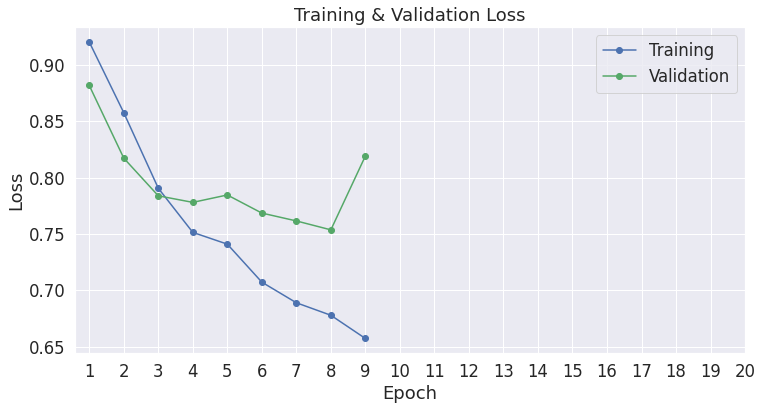

In [152]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])

plt.show()

In [196]:
import os


output_dir = 'model_IAN_restaurents_with_attention/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)




Saving model to model_IAN_restaurents_with_attention/


In [197]:
  import json
  torch.save(model.state_dict(), os.path.join(output_dir, 'model_weights'))
  # with open(os.path.join(output_dir, 'model_config.json'), 'w') as f:
  #     json.dump(model.config, f)

In [198]:
from google.colab import files


In [199]:
!zip -r model_IAN_restaurents_with_attention.zip model_IAN_restaurents_with_attention


  adding: model_IAN_restaurents_with_attention/ (stored 0%)
  adding: model_IAN_restaurents_with_attention/model_weights (deflated 11%)


In [240]:
files.download('model_IAN_restaurents_with_attention.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [232]:
!unzip model_IAN_restaurents_with_attention.zip

Archive:  model_IAN_restaurents_with_attention.zip
replace model_IAN_restaurents_with_attention/model_weights? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: model_IAN_restaurents_with_attention/model_weights  


In [233]:
# model2 = IANClassifier(aspect.vocab.vectors,text.vocab.vectors, hidden_dim=300, lstm_layer=1, dropout=0.5).cuda()

model.load_state_dict(torch.load('model_IAN_restaurents_with_attention/model_weights'))

<All keys matched successfully>

In [234]:

# Prediction on test set

# print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in test_iter:
  # Add batch to GPU
  context_text, context_len = batch.text
  context_text = context_text.cuda()

  aspect_text, aspect_len = batch.aspect
  aspect_text = aspect_text.cuda()
  # outs = sigmoid(outs.cpu().data.numpy()).tolist()
  y = batch.target.type(torch.long).cuda()

  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
    outputs = model.forward(context_text, context_len,aspect_text,aspect_len) 

  logits = outputs
  # _,logits = logits.max(dim=1)

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = y.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

    DONE.


In [235]:
flat_predictions = np.concatenate(predictions, axis=0)

flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

In [236]:
flat_predictions

array([2, 2, 2, ..., 0, 2, 2])

In [237]:
from sklearn.metrics import accuracy_score
accuracy_score(flat_true_labels,flat_predictions)

0.7642857142857142

In [238]:
def accuracy_per_class(preds_flat, labels_flat):

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {get_labels(label)}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [239]:
accuracy_per_class(flat_predictions,flat_true_labels)

Class: negative
Accuracy: 111/196

Class: neutral
Accuracy: 65/196

Class: positive
Accuracy: 680/728

